In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from keras.layers import TimeDistributed, GlobalAveragePooling1D, GlobalAveragePooling2D, BatchNormalization
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, AveragePooling1D
from keras.layers.embeddings import Embedding
from keras.layers import Dropout, Flatten, Bidirectional, Dense, Activation, TimeDistributed
from keras.models import Model, Sequential
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from string import ascii_lowercase
from collections import Counter
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models import doc2vec
from gensim.models import KeyedVectors
import itertools, nltk, snowballstemmer, re

LabeledSentence = doc2vec.LabeledSentence

Using TensorFlow backend.


In [2]:
class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources
        
        flipped = {}
        
        # make sure that keys are unique
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')
    
    def __iter__(self):
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no])
    
    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no]))
        return self.sentences
    
    def sentences_perm(self):
        shuffled = list(self.sentences)
        random.shuffle(shuffled)
        return shuffled

In [3]:
#data = pd.read_csv('deceptive-opinion-spam-corpus.zip', compression='zip', header=0, sep=',', quotechar='"')
data = pd.read_csv("../input/deceptive-opinion.csv")

In [4]:
data['polarity'] = np.where(data['polarity']=='positive', 1, 0)
data['deceptive'] = np.where(data['deceptive']=='truthful', 1, 0)

In [5]:
data.head()

,deceptive,hotel,polarity,source,text
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...


In [6]:
df = data.sample(frac=1)

In [7]:
df.head()

,deceptive,hotel,polarity,source,text
1287,0,swissotel,0,MTurk,I booked a room at Swissotel Chicago because I...
51,1,fairmont,1,TripAdvisor,We got this hotel by chance since we decided t...
1252,0,fairmont,0,MTurk,If you want a 5-star hotel with 1-star service...
505,0,swissotel,1,MTurk,When I was asked to stay at the Swissotel in C...
444,0,omni,1,MTurk,"The Omni Chicago is hands down, the best hotel..."


In [9]:
df.describe()

,deceptive,polarity
count,1600.000000,1600.000000
mean,0.500000,0.500000
std,0.500156,0.500156
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.500000,0.500000
75%,1.000000,1.000000
max,1.000000,1.000000


In [10]:
def create_class(c):
    if c['polarity'] == 1 and c['deceptive'] == 1:
        return [1,1]
    elif c['polarity'] == 1 and c['deceptive'] == 0:
        return [1,0]
    elif c['polarity'] == 0 and c['deceptive'] == 1:
        return [0,1]
    else:
        return [0,0]
    
def specific_class(c):
    if c['polarity'] == 1 and c['deceptive'] == 1:
        return "TRUE_POSITIVE"
    elif c['polarity'] == 1 and c['deceptive'] == 0:
        return "FALSE_POSITIVE"
    elif c['polarity'] == 0 and c['deceptive'] == 1:
        return "TRUE_NEGATIVE"
    else:
        return "FALSE_NEGATIVE"

data['final_class'] = data.apply(create_class, axis=1)
data['given_class'] = data.apply(specific_class, axis=1)

In [11]:
data['final_class']

0       [1, 1]
1       [1, 1]
2       [1, 1]
3       [1, 1]
4       [1, 1]
5       [1, 1]
6       [1, 1]
7       [1, 1]
8       [1, 1]
9       [1, 1]
10      [1, 1]
11      [1, 1]
12      [1, 1]
13      [1, 1]
14      [1, 1]
15      [1, 1]
16      [1, 1]
17      [1, 1]
18      [1, 1]
19      [1, 1]
20      [1, 1]
21      [1, 1]
22      [1, 1]
23      [1, 1]
24      [1, 1]
25      [1, 1]
26      [1, 1]
27      [1, 1]
28      [1, 1]
29      [1, 1]
         ...  
1570    [0, 0]
1571    [0, 0]
1572    [0, 0]
1573    [0, 0]
1574    [0, 0]
1575    [0, 0]
1576    [0, 0]
1577    [0, 0]
1578    [0, 0]
1579    [0, 0]
1580    [0, 0]
1581    [0, 0]
1582    [0, 0]
1583    [0, 0]
1584    [0, 0]
1585    [0, 0]
1586    [0, 0]
1587    [0, 0]
1588    [0, 0]
1589    [0, 0]
1590    [0, 0]
1591    [0, 0]
1592    [0, 0]
1593    [0, 0]
1594    [0, 0]
1595    [0, 0]
1596    [0, 0]
1597    [0, 0]
1598    [0, 0]
1599    [0, 0]
Name: final_class, Length: 1600, dtype: object

In [13]:
data.head()

,deceptive,hotel,polarity,source,text,final_class,given_class
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...,"[1, 1]",TRUE_POSITIVE
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...,"[1, 1]",TRUE_POSITIVE
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...,"[1, 1]",TRUE_POSITIVE
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...,"[1, 1]",TRUE_POSITIVE
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...,"[1, 1]",TRUE_POSITIVE


In [24]:
 # Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
data['given_class']= label_encoder.fit_transform(data['given_class']) 

In [25]:
data['given_class'].unique()

array([3, 1, 2, 0])

In [41]:
Y = data['given_class']
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [26]:
data.head()

,deceptive,hotel,polarity,source,text,final_class,given_class,stemmed_text_data
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...,"[1, 1]",3,stay night getaway famili thursday tripl aaa r...
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...,"[1, 1]",3,tripl rate upgrad view room less $ includ brea...
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...,"[1, 1]",3,come littl late final catch review past sever ...
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...,"[1, 1]",3,omni chicago realli deliv front spacious room ...
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...,"[1, 1]",3,ask high floor away elev got room pleasant dec...


In [15]:
textData = pd.DataFrame(list(data['text'])) # each row is one document; the raw text of the document should be in the 'text_data' column

In [16]:
# initialize stemmer
stemmer = snowballstemmer.EnglishStemmer()

# grab stopword list, extend it a bit, and then turn it into a set for later
stop = stopwords.words('english')
stop.extend(['may','also','zero','one','two','three','four','five','six','seven','eight','nine','ten','across','among','beside','however','yet','within']+list(ascii_lowercase))
stoplist = stemmer.stemWords(stop)
stoplist = set(stoplist)
stop = set(sorted(stop + list(stoplist))) 

In [17]:
# remove characters and stoplist words, then generate dictionary of unique words
textData[0].replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\]',' ',inplace=True,regex=True)
wordlist = filter(None, " ".join(list(set(list(itertools.chain(*textData[0].str.split(' ')))))).split(" "))
data['stemmed_text_data'] = [' '.join(filter(None,filter(lambda word: word not in stop, line))) for line in textData[0].str.lower().str.split(' ')]

In [18]:
# remove all words that don't occur at least 5 times and then stem the resulting docs
minimum_count = 1
str_frequencies = pd.DataFrame(list(Counter(filter(None,list(itertools.chain(*data['stemmed_text_data'].str.split(' '))))).items()),columns=['word','count'])
low_frequency_words = set(str_frequencies[str_frequencies['count'] < minimum_count]['word'])
data['stemmed_text_data'] = [' '.join(filter(None,filter(lambda word: word not in low_frequency_words, line))) for line in data['stemmed_text_data'].str.split(' ')]
data['stemmed_text_data'] = [" ".join(stemmer.stemWords(re.sub('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\]',' ', next_text).split(' '))) for next_text in data['stemmed_text_data']]    

In [19]:
lmtzr = WordNetLemmatizer()
w = re.compile("\w+",re.I)

def label_sentences(df, input_point):
    labeled_sentences = []
    list_sen = []
    for index, datapoint in df.iterrows():
        tokenized_words = re.findall(w,datapoint[input_point].lower())
        labeled_sentences.append(LabeledSentence(words=tokenized_words, tags=['SENT_%s' %index]))
        list_sen.append(tokenized_words)
    return labeled_sentences, list_sen

def train_doc2vec_model(labeled_sentences):
    model = Doc2Vec(min_count=1, window=9, size=512, sample=1e-4, negative=5, workers=7)
    model.build_vocab(labeled_sentences)
    pretrained_weights = model.wv.syn0
    vocab_size, embedding_size = pretrained_weights.shape
    model.train(labeled_sentences, total_examples=vocab_size, epochs=400)
    
    return model

In [20]:
textData = data['stemmed_text_data'].to_frame().reset_index()
sen, corpus = label_sentences(textData, 'stemmed_text_data')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  if __name__ == '__main__':


In [21]:
doc2vec_model = train_doc2vec_model(sen)

/opt/conda/lib/python3.6/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  app.launch_new_instance()


In [22]:
doc2vec_model.save("doc2vec_model_opinion_corpus.d2v")

In [27]:
doc2vec_model = Doc2Vec.load("doc2vec_model_opinion_corpus.d2v") 

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

tfidf1 = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, ngram_range=(1,1))
result_train1 = tfidf1.fit_transform(corpus)

tfidf2 = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, ngram_range=(1,2))
result_train2 = tfidf2.fit_transform(corpus)

tfidf3 = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, ngram_range=(1,3))
result_train3 = tfidf3.fit_transform(corpus)

svd = TruncatedSVD(n_components=512, n_iter=40, random_state=34)
tfidf_data1 = svd.fit_transform(result_train1)
tfidf_data2 = svd.fit_transform(result_train2)
tfidf_data3 = svd.fit_transform(result_train3)

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
import spacy

nlp = spacy.load('en')
temp_textData = pd.DataFrame(list(data['text']))

overall_pos_tags_tokens = []
overall_pos = []
overall_tokens = []
overall_dep = []

for i in range(1600):
    doc = nlp(temp_textData[0][i])
    given_pos_tags_tokens = []
    given_pos = []
    given_tokens = []
    given_dep = []
    for token in doc:
        output = "%s_%s" % (token.pos_, token.tag_)
        given_pos_tags_tokens.append(output)
        given_pos.append(token.pos_)
        given_tokens.append(token.tag_)
        given_dep.append(token.dep_)
        
    overall_pos_tags_tokens.append(given_pos_tags_tokens)
    overall_pos.append(given_pos)
    overall_tokens.append(given_tokens)
    overall_dep.append(given_dep)


In [30]:
from sklearn.preprocessing import MinMaxScaler

count = CountVectorizer(tokenizer=lambda i:i, lowercase=False)
pos_tags_data = count.fit_transform(overall_pos_tags_tokens).todense()
pos_data = count.fit_transform(overall_pos).todense()
tokens_data = count.fit_transform(overall_tokens).todense()
dep_data = count.fit_transform(overall_dep).todense()
min_max_scaler = MinMaxScaler()
normalized_pos_tags_data = min_max_scaler.fit_transform(pos_tags_data)
normalized_pos_data = min_max_scaler.fit_transform(pos_data)
normalized_tokens_data = min_max_scaler.fit_transform(tokens_data)
normalized_dep_data = min_max_scaler.fit_transform(dep_data)

final_pos_tags_data = np.zeros(shape=(1600, 512)).astype(np.float32)
final_pos_data = np.zeros(shape=(1600, 512)).astype(np.float32)
final_tokens_data = np.zeros(shape=(1600, 512)).astype(np.float32)
final_dep_data = np.zeros(shape=(1600, 512)).astype(np.float32)
final_pos_tags_data[:normalized_pos_tags_data.shape[0],:normalized_pos_tags_data.shape[1]] = normalized_pos_tags_data
final_pos_data[:normalized_pos_data.shape[0],:normalized_pos_data.shape[1]] = normalized_pos_data
final_tokens_data[:normalized_tokens_data.shape[0],:normalized_tokens_data.shape[1]] = normalized_tokens_data
final_dep_data[:normalized_dep_data.shape[0],:normalized_dep_data.shape[1]] = normalized_dep_data

In [31]:
maxlength = []
for i in range(0,len(sen)):
    maxlength.append(len(sen[i][0]))
    
print(max(maxlength))   

370


In [32]:
def vectorize_comments(df,d2v_model):
    y = []
    comments = []
    for i in range(0,df.shape[0]):
        label = 'SENT_%s' %i
        comments.append(d2v_model.docvecs[label])
    df['vectorized_comments'] = comments
    
    return df

textData = vectorize_comments(textData,doc2vec_model)
print (textData.head(2))

   index                                  stemmed_text_data  \
0      0  stay night getaway famili thursday tripl aaa r...   
1      1  tripl rate upgrad view room less $ includ brea...   

                                 vectorized_comments  
0  [-0.16477892, 0.8602185, -0.18892144, -0.03193...  
1  [-0.4564898, 0.27204838, -0.68110913, -0.07261...  


In [33]:
# load the whole embedding into memory
#embeddings_index = dict()
#f = open('glove/glove.6B.300d.txt')
#for line in f:
#    values = line.split()
#    word = values[0]
#    coefs = np.asarray(values[1:], dtype='float32')
#    embeddings_index[word] = coefs
#f.close()
#print('Loaded %s word vectors.' % len(embeddings_index))

In [ ]:
#from nltk.corpus import stopwords

#glove_data = np.zeros(shape=(1600, 800, 512)).astype(np.float32)
#temp_textData = data['text'].to_frame().reset_index()
#sen2, corpus2 = label_sentences(temp_textData, 'text')
#stop_words = set(stopwords.words('english'))
#test_word = np.zeros(512).astype(np.float32)
#final_matrix = np.zeros(512).astype(np.float32)
#final_sizes = []

#count = True

#for i in range(1600):
#    for j in sen2[i][0]:
#        if j in embeddings_index and j not in stop_words:
#            test_word[:300] = embeddings_index[j]
#            if count == True:
#                final_matrix = test_word
#                count = False
#            else:
#                final_matrix = np.vstack((final_matrix, test_word))
            
#    final_sizes.append(final_matrix.shape[0])
#    final_matrix = np.zeros(512).astype(np.float32)
#    glove_data[i,:final_matrix.shape[0],:] = final_matrix
#    count = True
    
#print(max(final_sizes))

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate,GridSearchCV 

X_train, X_test, y_train, y_test = train_test_split(textData["vectorized_comments"].T.tolist(), 
                                                                     dummy_y, 
                                                                     test_size=0.1, 
                                                                     random_state=56)

In [58]:
X = np.array(textData["vectorized_comments"].T.tolist()).reshape((1,1600,512))
y = np.array(dummy_y).reshape((1600,4))
X_train2 = np.array(X_train).reshape((1,1440,512))
y_train2 = np.array(y_train).reshape((1,1440,4))
X_test2 = np.array(X_test).reshape((1,160,512))
y_test2 = np.array(y_test).reshape((1,160,4))

In [44]:
from sklearn.model_selection import StratifiedKFold
Xtemp = textData["vectorized_comments"].T.tolist()
ytemp = data['given_class']
training_indices = []
testing_indices = []

skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(Xtemp, ytemp)

for train_index, test_index in skf.split(Xtemp, ytemp):
    training_indices.append(train_index)
    testing_indices.append(test_index)

In [45]:
def extractTrainingAndTestingData(givenIndex):
    X_train3 = np.zeros(shape=(1440, max(maxlength)+10, 512)).astype(np.float32)
    Y_train3 = np.zeros(shape=(1440, 4)).astype(np.float32)
    X_test3 = np.zeros(shape=(160, max(maxlength)+10, 512)).astype(np.float32)
    Y_test3 = np.zeros(shape=(160, 4)).astype(np.float32)

    empty_word = np.zeros(512).astype(np.float32)

    count_i = 0
    for i in training_indices[givenIndex]:
        len1 = len(sen[i][0])
        average_vector1 = np.zeros(512).astype(np.float32)
        average_vector2 = np.zeros(512).astype(np.float32)
        average_vector3 = np.zeros(512).astype(np.float32)
        for j in range(max(maxlength)+10):
            if j < len1:
                X_train3[count_i,j,:] = doc2vec_model[sen[i][0][j]]
                average_vector1 += result_train1[i, tfidf1.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
                average_vector2 += result_train2[i, tfidf2.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
                average_vector3 += result_train3[i, tfidf3.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
            #elif j >= len1 and j < len1 + 379:
            #    X_train3[count_i,j,:] = glove_data[i, j-len1, :]
            elif j == len1:
                X_train3[count_i,j,:] = tfidf_data1[i]
            elif j == len1 + 1:
                X_train3[count_i,j,:] = tfidf_data2[i]
            elif j == len1+2:
                X_train3[count_i,j,:] = tfidf_data3[i]
            elif j == len1+3:
                X_train3[count_i,j,:] = average_vector1
            elif j == len1+4:
                X_train3[count_i,j,:] = average_vector2
            elif j == len1+5:
                X_train3[count_i,j,:] = average_vector3
            elif j == len1+6:
                X_train3[count_i,j,:] = final_pos_tags_data[i] 
            elif j == len1+7:
                X_train3[count_i,j,:] = final_pos_data[i]
            elif j == len1+8:
                X_train3[count_i,j,:] = final_tokens_data[i]
            elif j == len1+9:
                X_train3[count_i,j,:] = final_dep_data[i]
            else:
                X_train3[count_i,j,:] = empty_word

        Y_train3[count_i,:] = dummy_y[i]
        count_i += 1


    count_i = 0
    for i in testing_indices[givenIndex]:
        len1 = len(sen[i][0])
        average_vector1 = np.zeros(512).astype(np.float32)
        average_vector2 = np.zeros(512).astype(np.float32)
        average_vector3 = np.zeros(512).astype(np.float32)
        for j in range(max(maxlength)+10):
            if j < len1:
                X_test3[count_i,j,:] = doc2vec_model[sen[i][0][j]]
                average_vector1 += result_train1[i, tfidf1.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
                average_vector2 += result_train2[i, tfidf2.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]  
                average_vector3 += result_train3[i, tfidf3.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
            #elif j >= len1 and j < len1 + 379:
            #    X_test3[count_i,j,:] = glove_data[i, j-len1, :]
            elif j == len1:
                X_test3[count_i,j,:] = tfidf_data1[i]
            elif j == len1 + 1:
                X_test3[count_i,j,:] = tfidf_data2[i]
            elif j == len1+2:
                X_test3[count_i,j,:] = tfidf_data3[i]
            elif j == len1+3:
                X_test3[count_i,j,:] = average_vector1
            elif j == len1+4:
                X_test3[count_i,j,:] = average_vector2
            elif j == len1+5:
                X_test3[count_i,j,:] = average_vector3
            elif j == len1+6:
                X_test3[count_i,j,:] = final_pos_tags_data[i]
            elif j == len1+7:
                X_test3[count_i,j,:] = final_pos_data[i]
            elif j == len1+8:
                X_test3[count_i,j,:] = final_tokens_data[i]
            elif j == len1+9:
                X_test3[count_i,j,:] = final_dep_data[i]
            else:
                X_test3[count_i,j,:] = empty_word

        Y_test3[count_i,:] = dummy_y[i]
        count_i += 1
        
    return X_train3, X_test3, Y_train3, Y_test3
    

In [66]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=9, padding='same', activation='relu', input_shape=(max(maxlength)+10,512)))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(filters=128, kernel_size=7, padding='same', activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(Dropout(0.25))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.25))
#model.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
#model.add(Dropout(0.25))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.25))

#model.add(Bidirectional(LSTM(50, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(50, dropout=0.25, recurrent_dropout=0.2)))
model.add(Dense(4, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 380, 128)          589952    
_________________________________________________________________
dropout_11 (Dropout)         (None, 380, 128)          0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 190, 128)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 190, 128)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 190, 128)          114816    
_________________________________________________________________
dropout_13 (Dropout)         (None, 190, 128)          0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 95, 128)           0         
__________

In [67]:
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint 

final_accuracies = []
    
filename = 'weights.best.from_scratch%s.hdf5' % 9
checkpointer = ModelCheckpoint(filepath=filename, verbose=1, save_best_only=True)
X_train3, X_test3, Y_train3, Y_test3 = extractTrainingAndTestingData(9)

In [68]:
history = model.fit(X_train3, Y_train3, epochs=15, batch_size=512, callbacks=[checkpointer], validation_data=(X_test3, Y_test3), verbose=1)

Train on 1440 samples, validate on 160 samples
Epoch 1/15
1440/1440 [==============================] - 27s 19ms/step - loss: 0.5636 - acc: 0.7500 - val_loss: 0.5463 - val_acc: 0.7500

Epoch 00001: val_loss improved from inf to 0.54633, saving model to weights.best.from_scratch9.hdf5
Epoch 2/15
1440/1440 [==============================] - 23s 16ms/step - loss: 0.5367 - acc: 0.7500 - val_loss: 0.4850 - val_acc: 0.7500

Epoch 00002: val_loss improved from 0.54633 to 0.48500, saving model to weights.best.from_scratch9.hdf5
Epoch 3/15
1440/1440 [==============================] - 23s 16ms/step - loss: 0.4753 - acc: 0.7547 - val_loss: 0.4232 - val_acc: 0.7922

Epoch 00003: val_loss improved from 0.48500 to 0.42325, saving model to weights.best.from_scratch9.hdf5
Epoch 4/15
1440/1440 [==============================] - 23s 16ms/step - loss: 0.4176 - acc: 0.7884 - val_loss: 0.3655 - val_acc: 0.8313

Epoch 00004: val_loss improved from 0.42325 to 0.36548, saving model to weights.best.from_scratch

In [69]:
model.evaluate(X_test3, Y_test3)

160/160 [==============================] - 1s 6ms/step


[0.20703359246253966, 0.921875]

In [70]:
import matplotlib.pyplot as plt

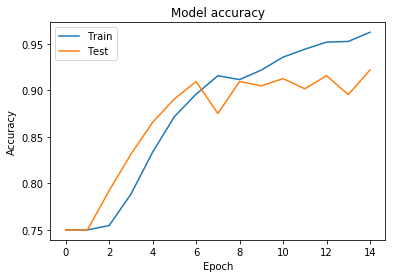

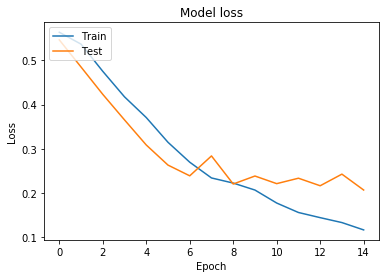

In [71]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.load_weights(filename)

In [ ]:
for i in range(10):
    filename = 'weights.best.from_scratch%s.hdf5' % i
    checkpointer = ModelCheckpoint(filepath=filename, verbose=1, save_best_only=True)
    X_train3, X_test3, Y_train3, Y_test3 = extractTrainingAndTestingData(i)
    model.fit(X_train3, Y_train3, epochs=10, batch_size=512, callbacks=[checkpointer], validation_data=(X_test3, Y_test3))
    model.load_weights(filename)
    predicted = np.rint(model.predict(X_test3))
    final_accuracies.append(accuracy_score(Y_test3, predicted))
    print(accuracy_score(Y_test3, predicted))

In [ ]:
print(sum(final_accuracies) / len(final_accuracies))